# ASO Efficacy Prediction: ML Analysis Pipeline

This notebook performs comprehensive machine learning analysis on ASO (Antisense Oligonucleotide) data including:
- Column selection and data cleaning
- Feature engineering and preprocessing
- Model training and evaluation
- Feature importance analysis
- Results visualization and interpretation

## Table of Contents
1. [Data Loading and Exploration](#1-data-loading-and-exploration)
2. [Column Selection and Cleaning](#2-column-selection-and-cleaning)
3. [Feature Engineering](#3-feature-engineering)
4. [Model Training](#4-model-training)
5. [Feature Importance Analysis](#5-feature-importance-analysis)
6. [Results and Visualization](#6-results-and-visualization)
7. [Model Interpretation](#7-model-interpretation)

## 1. Data Loading and Exploration

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the data
data_path = 'comprehensive_aso_analysis_complete.csv'  # Update this path as needed
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Dataset shape: (10729, 49)

Columns (49):
 1. source_type
 2. name
 3. id
 4. target_gene
 5. exon_or_intron
 6. number_exon_intron
 7. target_variant
 8. species
 9. cell_line
10. delivery_approach
11. aso_type
12. oligo_sequence
13. modification
14. modification_mask
15. concentration
16. concentration_unit
17. type_of_efficiency
18. efficiency
19. efficiency_units
20. efficiency_text
21. comment
22. DNA.RNA
23. link
24. top1_hit
25. top1_real
26. top1_predicted
27. no_mod_ASO
28. no_mod_ASO_count
29. no_mod_ASO_max_length
30. no_mod_ASO_has_homopolymers
31. no_mod_ASO_length
32. no_mod_ASO_gc_content
33. molecular_weight
34. converted_value_uM
35. a_numeric
36. gene_symbol
37. exon_number
38. sequence
39. sequence_count
40. sequence_max_length
41. sequence_has_homopolymers
42. sequence_length
43. sequence_gc_content
44. bestdG
45. binding_site
46. MFE_ASO
47. mfe_aso_structure
48. MFE_exon
49. mfe_exon_structure


In [4]:
# Basic data exploration
print("=== BASIC DATA INFORMATION ===")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== DATA TYPES ===")
print(df.dtypes.value_counts())

print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0].head(10))

=== BASIC DATA INFORMATION ===
Dataset shape: (10729, 49)
Memory usage: 22.57 MB

=== DATA TYPES ===
object     25
float64    16
int64       6
bool        2
Name: count, dtype: int64

=== MISSING VALUES ===
                   Missing Count  Missing Percentage
target_variant             10729          100.000000
modification_mask          10729          100.000000
aso_type                   10729          100.000000
efficiency_text            10729          100.000000
efficiency_units           10729          100.000000
comment                    10729          100.000000
top1_real                  10713           99.850871
top1_predicted             10713           99.850871
top1_hit                   10713           99.850871
binding_site                 130            1.211669


In [5]:
# Examine the target variable (efficiency)
print("=== TARGET VARIABLE ANALYSIS ===")
print("\nEfficiency column unique values:")
print(df['efficiency'].value_counts().head(20))

print("\nEfficiency data types:")
print(df['efficiency'].apply(type).value_counts())

# Check for text values in efficiency
text_efficiency = df[df['efficiency'].astype(str).str.contains(r'[a-zA-Z]', na=False)]['efficiency'].unique()
print(f"\nText values in efficiency: {text_efficiency}")

=== TARGET VARIABLE ANALYSIS ===

Efficiency column unique values:
efficiency
Null                                 1485
unspecified                           978
0                                     764
No skipping                           165
Skipping                              142
25                                    134
10                                    131
skipping of exon 21 was confirmed      88
No Skipping                            79
skipping                               75
30                                     56
no skipping                            54
skipping of exon 24 was observed       51
skipping of exon 24 was confinned      48
strong skipping                        47
+                                      46
skipping of exon 20 was observed       45
40                                     42
faint                                  38
0.1                                    37
Name: count, dtype: int64

Efficiency data types:
efficiency
<class 'str'>    1072

## 2. Column Selection and Cleaning

In [6]:
# Define column categories for analysis
print("=== COLUMN CATEGORIZATION ===")

# Columns to potentially remove (metadata, identifiers, redundant)
columns_to_remove = [
    'source_type',           # Metadata
    'name',                  # Identifier
    'id',                    # Identifier
    'link',                  # Metadata
    'comment',               # Text field
    'efficiency_text',       # Text field
    'efficiency_units',      # Redundant with type_of_efficiency
    'modification_mask',     # Complex encoding, use modification instead
    'mfe_aso_structure',     # Structure string, use MFE_ASO value
    'mfe_exon_structure',    # Structure string, use MFE_exon value
    'binding_site',          # Sequence string, use bestdG value
    'top1_hit',              # Error values
    'top1_real',             # Error values
    'top1_predicted',        # Error values
    'no_mod_ASO',            # Redundant with oligo_sequence
    'sequence'               # Redundant with oligo_sequence
]

# Target variable
target_column = 'efficiency'

# Potential feature columns (to be refined)
potential_features = [
    # Categorical features
    'target_gene', 'exon_or_intron', 'species', 'cell_line',
    'delivery_approach', 'aso_type', 'modification', 'concentration_unit',
    'type_of_efficiency', 'DNA.RNA',

    # Numerical features - sequence properties
    'number_exon_intron', 'exon_number', 'a_numeric',
    'no_mod_ASO_length', 'no_mod_ASO_gc_content', 'sequence_length', 'sequence_gc_content',

    # Numerical features - homopolymer analysis
    'no_mod_ASO_count', 'no_mod_ASO_max_length', 'sequence_count', 'sequence_max_length',

    # Boolean features
    'no_mod_ASO_has_homopolymers', 'sequence_has_homopolymers',

    # Numerical features - thermodynamic
    'bestdG', 'MFE_ASO', 'MFE_exon',

    # Numerical features - concentration and molecular properties
    'concentration', 'molecular_weight', 'converted_value_uM',

    # Sequence identifier
    'oligo_sequence', 'gene_symbol'
]

print(f"Columns to remove: {len(columns_to_remove)}")
print(f"Potential features: {len(potential_features)}")
print(f"Target column: {target_column}")

=== COLUMN CATEGORIZATION ===
Columns to remove: 16
Potential features: 31
Target column: efficiency


In [7]:
# Create cleaned dataset
print("=== CREATING CLEANED DATASET ===")

# Remove unwanted columns
df_clean = df.drop(columns=[col for col in columns_to_remove if col in df.columns])
print(f"Removed {len([col for col in columns_to_remove if col in df.columns])} columns")

# Check which potential features are actually available
available_features = [col for col in potential_features if col in df_clean.columns]
missing_features = [col for col in potential_features if col not in df_clean.columns]

print(f"\nAvailable features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")
if missing_features:
    print(f"Missing: {missing_features}")

print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"Remaining columns: {list(df_clean.columns)}")

=== CREATING CLEANED DATASET ===
Removed 16 columns

Available features: 31
Missing features: 0

Cleaned dataset shape: (10729, 33)
Remaining columns: ['target_gene', 'exon_or_intron', 'number_exon_intron', 'target_variant', 'species', 'cell_line', 'delivery_approach', 'aso_type', 'oligo_sequence', 'modification', 'concentration', 'concentration_unit', 'type_of_efficiency', 'efficiency', 'DNA.RNA', 'no_mod_ASO_count', 'no_mod_ASO_max_length', 'no_mod_ASO_has_homopolymers', 'no_mod_ASO_length', 'no_mod_ASO_gc_content', 'molecular_weight', 'converted_value_uM', 'a_numeric', 'gene_symbol', 'exon_number', 'sequence_count', 'sequence_max_length', 'sequence_has_homopolymers', 'sequence_length', 'sequence_gc_content', 'bestdG', 'MFE_ASO', 'MFE_exon']


In [8]:
# Clean and convert the target variable
print("=== CLEANING TARGET VARIABLE ===")

def convert_efficiency_to_numeric(val):
    """Convert efficiency values to numeric, handling text cases"""
    if pd.isna(val):
        return np.nan

    if isinstance(val, str):
        val_lower = val.lower().strip()
        # Handle common text values
        if val_lower in ['unspecified', 'data not shown', 'not determined', 'nd', 'na', '']:
            return np.nan
        # Try to extract numeric value
        try:
            # Remove any non-numeric characters except decimal point and minus
            import re
            numeric_str = re.findall(r"-?\d+\.?\d*", val)
            if numeric_str:
                return float(numeric_str[0])
            else:
                return np.nan
        except:
            return np.nan

    try:
        return float(val)
    except:
        return np.nan

# Apply conversion
df_clean['efficiency_numeric'] = df_clean['efficiency'].apply(convert_efficiency_to_numeric)

# Analyze the conversion results
print(f"Original efficiency values: {len(df_clean)}")
print(f"Valid numeric efficiency values: {df_clean['efficiency_numeric'].notna().sum()}")
print(f"Missing/invalid efficiency values: {df_clean['efficiency_numeric'].isna().sum()}")
print(f"Conversion success rate: {df_clean['efficiency_numeric'].notna().sum() / len(df_clean) * 100:.1f}%")

# Show efficiency statistics
print("\nEfficiency statistics:")
print(df_clean['efficiency_numeric'].describe())

=== CLEANING TARGET VARIABLE ===
Original efficiency values: 10729
Valid numeric efficiency values: 7295
Missing/invalid efficiency values: 3434
Conversion success rate: 68.0%

Efficiency statistics:
count    7295.000000
mean       30.601080
std        45.298456
min         0.000000
25%         4.000000
50%        20.000000
75%        45.955000
max      1000.000000
Name: efficiency_numeric, dtype: float64


=== REMOVING ROWS WITH MISSING TARGET ===
Rows before filtering: 10729
Rows after filtering: 7295
Rows removed: 3434


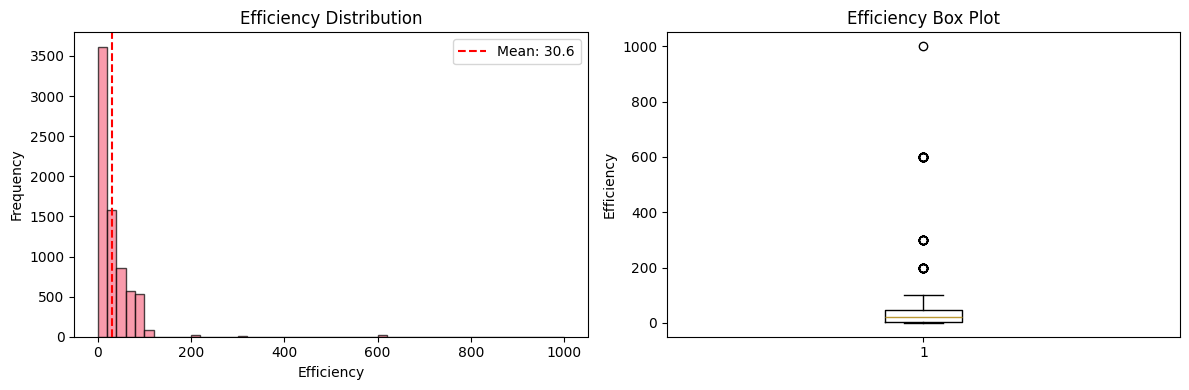


Efficiency range: [0.0, 1000.0]
Efficiency mean: 30.6
Efficiency median: 20.0


In [9]:
# Remove rows with missing target values
print("=== REMOVING ROWS WITH MISSING TARGET ===")

print(f"Rows before filtering: {len(df_clean)}")
df_clean = df_clean.dropna(subset=['efficiency_numeric'])
print(f"Rows after filtering: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Visualize efficiency distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean['efficiency_numeric'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Efficiency Distribution')
plt.axvline(df_clean['efficiency_numeric'].mean(), color='red', linestyle='--',
           label=f'Mean: {df_clean["efficiency_numeric"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['efficiency_numeric'])
plt.ylabel('Efficiency')
plt.title('Efficiency Box Plot')

plt.tight_layout()
plt.show()

print(f"\nEfficiency range: [{df_clean['efficiency_numeric'].min():.1f}, {df_clean['efficiency_numeric'].max():.1f}]")
print(f"Efficiency mean: {df_clean['efficiency_numeric'].mean():.1f}")
print(f"Efficiency median: {df_clean['efficiency_numeric'].median():.1f}")

## 3. Feature Engineering

In [10]:
# Categorize features by type
print("=== FEATURE CATEGORIZATION ===")

# Identify feature types based on available columns
numerical_features = []
categorical_features = []
boolean_features = []

for col in df_clean.columns:
    if col in ['efficiency', 'efficiency_numeric', 'oligo_sequence', 'gene_symbol', 'target_variant']:
        continue  # Skip target and sequence columns

    # Check data type and content
    if df_clean[col].dtype in ['int64', 'float64']:
        # Check if it's boolean (0/1 or True/False)
        unique_vals = df_clean[col].dropna().unique()
        if len(unique_vals) <= 2 and set(unique_vals).issubset({0, 1, True, False}):
            boolean_features.append(col)
        else:
            numerical_features.append(col)
    else:
        categorical_features.append(col)

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nBoolean features ({len(boolean_features)}): {boolean_features}")

=== FEATURE CATEGORIZATION ===
Numerical features (16): ['number_exon_intron', 'no_mod_ASO_count', 'no_mod_ASO_max_length', 'no_mod_ASO_length', 'no_mod_ASO_gc_content', 'molecular_weight', 'converted_value_uM', 'a_numeric', 'exon_number', 'sequence_count', 'sequence_max_length', 'sequence_length', 'sequence_gc_content', 'bestdG', 'MFE_ASO', 'MFE_exon']

Categorical features (12): ['target_gene', 'exon_or_intron', 'species', 'cell_line', 'delivery_approach', 'modification', 'concentration', 'concentration_unit', 'type_of_efficiency', 'DNA.RNA', 'no_mod_ASO_has_homopolymers', 'sequence_has_homopolymers']

Boolean features (1): ['aso_type']


In [11]:
# Analyze feature quality and completeness
print("=== FEATURE QUALITY ANALYSIS ===")

feature_analysis = []

all_features = numerical_features + categorical_features + boolean_features

for feature in all_features:
    missing_count = df_clean[feature].isna().sum()
    missing_pct = (missing_count / len(df_clean)) * 100
    unique_count = df_clean[feature].nunique()

    if feature in numerical_features:
        feature_type = 'Numerical'
        extra_info = f"Range: [{df_clean[feature].min():.2f}, {df_clean[feature].max():.2f}]"
    elif feature in categorical_features:
        feature_type = 'Categorical'
        extra_info = f"Top values: {list(df_clean[feature].value_counts().head(3).index)}"
    else:
        feature_type = 'Boolean'
        extra_info = f"Values: {list(df_clean[feature].unique())}"

    feature_analysis.append({
        'Feature': feature,
        'Type': feature_type,
        'Missing_Count': missing_count,
        'Missing_Pct': missing_pct,
        'Unique_Count': unique_count,
        'Extra_Info': extra_info
    })

feature_df = pd.DataFrame(feature_analysis)
feature_df = feature_df.sort_values('Missing_Pct')

print(feature_df.to_string(index=False))

=== FEATURE QUALITY ANALYSIS ===
                    Feature        Type  Missing_Count  Missing_Pct  Unique_Count                                                                       Extra_Info
         number_exon_intron   Numerical              0     0.000000            78                                                             Range: [1.00, 80.00]
           no_mod_ASO_count   Numerical              0     0.000000             5                                                              Range: [0.00, 4.00]
      no_mod_ASO_max_length   Numerical              0     0.000000             8                                                             Range: [0.00, 13.00]
          no_mod_ASO_length   Numerical              0     0.000000            52                                                            Range: [2.00, 371.00]
      no_mod_ASO_gc_content   Numerical              0     0.000000           198                                                             Range: [8.

In [12]:
# Handle categorical variables
print("=== PROCESSING CATEGORICAL VARIABLES ===")

# Create a copy for feature engineering
df_features = df_clean.copy()

# Store label encoders
label_encoders = {}

for cat_feature in categorical_features:
    print(f"\nProcessing {cat_feature}:")

    # Fill missing values
    df_features[cat_feature] = df_features[cat_feature].fillna('Unknown')

    # Show unique values
    unique_vals = df_features[cat_feature].unique()
    print(f"  Unique values ({len(unique_vals)}): {unique_vals[:10]}{'...' if len(unique_vals) > 10 else ''}")

    # Label encoding
    le = LabelEncoder()
    df_features[f'{cat_feature}_encoded'] = le.fit_transform(df_features[cat_feature])
    label_encoders[cat_feature] = le

    # One-hot encoding for features with reasonable number of categories
    if len(unique_vals) <= 20:  # Only create dummies for features with <= 20 categories
        dummies = pd.get_dummies(df_features[cat_feature], prefix=cat_feature, drop_first=True)
        df_features = pd.concat([df_features, dummies], axis=1)
        print(f"  Created {len(dummies.columns)} dummy variables")
    else:
        print(f"  Too many categories ({len(unique_vals)}), using label encoding only")

print(f"\nDataset shape after categorical processing: {df_features.shape}")

=== PROCESSING CATEGORICAL VARIABLES ===

Processing target_gene:
  Unique values (34): ['DMD' 'DYSF' 'MAPT' 'USH2A' 'COL7A1' 'PAH' 'NF1' 'AKR1A1' 'ABCA4' 'SCN1A']...
  Too many categories (34), using label encoding only

Processing exon_or_intron:
  Unique values (2): ['exon' 'exon ']
  Created 1 dummy variables

Processing species:
  Unique values (1): ['human']
  Created 0 dummy variables

Processing cell_line:
  Unique values (190): ['Primary healthy human myotubes' 'Primary patient myotubes (del45)'
 'cultured myogenic cells from a DMD patient with a deletion in exon 50'
 'normal human skeletal muscle primary cells with EPC at molar charge ratios of 0.1:0'
 'normal human skeletal muscle primary cells with EPC at molar charge ratios of 0.05:1'
 'normal human skeletal muscle primary cells with EPC at molar charge ratios of 0.25:1'
 'normal human skeletal muscle primary cells with EPC at molar charge ratios of 0.5:1'
 'normal human skeletal muscle primary cells with C20-20 at molar c

In [13]:
# Fixed version of the feature matrix preparation cell

print("=== PREPARING FINAL FEATURE MATRIX ===")

# Collect all feature columns - ONLY NUMERIC ONES
final_features = []

# Add numerical features (already numeric)
final_features.extend(numerical_features)
print(f"Added {len(numerical_features)} numerical features")

# Add boolean features (convert to int, handle NaN values first)
for bool_feature in boolean_features:
    df_features[bool_feature] = df_features[bool_feature].fillna(0).astype(int)
    final_features.append(bool_feature)
print(f"Added {len(boolean_features)} boolean features")

# Add ONLY encoded categorical features (not the original string columns)
encoded_categorical_features = []
for cat_feature in categorical_features:
    encoded_col = f'{cat_feature}_encoded'
    if encoded_col in df_features.columns:
        final_features.append(encoded_col)
        encoded_categorical_features.append(encoded_col)
print(f"Added {len(encoded_categorical_features)} encoded categorical features")

# Add dummy variables (these are already numeric 0/1)
dummy_cols = []
for col in df_features.columns:
    # Check if it's a dummy variable created from categorical features
    if any(cat_feature in col for cat_feature in categorical_features):
        # Skip the original categorical columns and encoded versions
        if col not in categorical_features and col not in encoded_categorical_features:
            # This should be a dummy variable
            if col not in final_features:
                dummy_cols.append(col)

final_features.extend(dummy_cols)
print(f"Added {len(dummy_cols)} dummy variables")

# Remove duplicates and ensure all columns exist
final_features = list(set(final_features))
final_features = [col for col in final_features if col in df_features.columns]

print(f"\\nTotal features selected: {len(final_features)}")
print(f"Feature types breakdown:")
print(f"  - Numerical: {len(numerical_features)}")
print(f"  - Boolean: {len(boolean_features)}")
print(f"  - Categorical (encoded): {len(encoded_categorical_features)}")
print(f"  - Dummy variables: {len(dummy_cols)}")

# Create feature matrix
X = df_features[final_features]
y = df_features['efficiency_numeric']

print(f"\\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# IMPORTANT: Check data types before imputation
print("\\nChecking data types before imputation:")
non_numeric_cols = []
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        non_numeric_cols.append(col)
        print(f"  WARNING: {col} is still non-numeric ({X[col].dtype})")
        # Show some sample values
        print(f"    Sample values: {X[col].dropna().unique()[:5]}")

if non_numeric_cols:
    print(f"\\nERROR: Found {len(non_numeric_cols)} non-numeric columns!")
    print("Attempting to convert them...")

    for col in non_numeric_cols:
        try:
            # Try to convert to numeric
            X[col] = pd.to_numeric(X[col], errors='coerce')
            print(f"  Converted {col} to numeric")
        except:
            print(f"  Failed to convert {col}, removing from features")
            X = X.drop(columns=[col])
            final_features.remove(col)

print(f"\\nFinal feature matrix shape after cleanup: {X.shape}")

# Handle missing values in features
print("\\nHandling missing values in features...")
missing_before = X.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before}")

if missing_before > 0:
    # Use median imputation for numerical features (now all should be numeric)
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

    missing_after = X_imputed.isnull().sum().sum()
    print(f"Missing values after imputation: {missing_after}")

    X = X_imputed
else:
    print("No missing values found, skipping imputation")

print("\\n✓ Feature matrix preparation completed successfully!")




=== PREPARING FINAL FEATURE MATRIX ===
Added 16 numerical features
Added 1 boolean features
Added 12 encoded categorical features
Added 51 dummy variables
\nTotal features selected: 80
Feature types breakdown:
  - Numerical: 16
  - Boolean: 1
  - Categorical (encoded): 12
  - Dummy variables: 51
\nFeature matrix shape: (7295, 80)
Target vector shape: (7295,)
\nChecking data types before imputation:
\nFinal feature matrix shape after cleanup: (7295, 80)
\nHandling missing values in features...
Missing values before imputation: 1
Missing values after imputation: 0
\n✓ Feature matrix preparation completed successfully!


## 4. Model Training

In [14]:
# Split the data
print("=== DATA SPLITTING ===")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target range: [{y_train.min():.1f}, {y_train.max():.1f}]")
print(f"Test target range: [{y_test.min():.1f}, {y_test.max():.1f}]")

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled for linear models")

=== DATA SPLITTING ===
Training set: (5836, 80)
Test set: (1459, 80)
Training target range: [0.0, 600.0]
Test target range: [0.0, 1000.0]

Features scaled for linear models


In [15]:
# Define and train baseline models
print("=== TRAINING BASELINE MODELS ===")

def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics"""
    return {
        'r2': r2_score(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred)
    }

# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    try:
        # Use scaled data for linear models
        if 'Regression' in name:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred)
        metrics['cv_mean'] = cv_scores.mean()
        metrics['cv_std'] = cv_scores.std()

        results[name] = {
            'model': model,
            'predictions': y_pred,
            'metrics': metrics
        }

        print(f"  R²: {metrics['r2']:.3f} (±{metrics['cv_std']:.3f})")
        print(f"  RMSE: {metrics['rmse']:.3f}")
        print(f"  MAE: {metrics['mae']:.3f}")

    except Exception as e:
        print(f"  Error training {name}: {e}")
        continue

print("\n=== BASELINE RESULTS SUMMARY ===")
for name, result in results.items():
    metrics = result['metrics']
    print(f"{name:20s} - R²: {metrics['r2']:.3f}, RMSE: {metrics['rmse']:.3f}, MAE: {metrics['mae']:.3f}")

=== TRAINING BASELINE MODELS ===

Training Random Forest...
  R²: 0.635 (±0.095)
  RMSE: 33.999
  MAE: 13.771

Training Gradient Boosting...
  R²: 0.599 (±0.077)
  RMSE: 35.630
  MAE: 18.991

Training Linear Regression...
  R²: 0.030 (±0.022)
  RMSE: 55.433
  MAE: 26.070

Training Ridge Regression...
  R²: 0.030 (±0.021)
  RMSE: 55.418
  MAE: 26.088

Training Lasso Regression...
  R²: 0.019 (±0.009)
  RMSE: 55.741
  MAE: 26.497

=== BASELINE RESULTS SUMMARY ===
Random Forest        - R²: 0.635, RMSE: 33.999, MAE: 13.771
Gradient Boosting    - R²: 0.599, RMSE: 35.630, MAE: 18.991
Linear Regression    - R²: 0.030, RMSE: 55.433, MAE: 26.070
Ridge Regression     - R²: 0.030, RMSE: 55.418, MAE: 26.088
Lasso Regression     - R²: 0.019, RMSE: 55.741, MAE: 26.497


In [ ]:
# Hyperparameter tuning for best models
print("=== HYPERPARAMETER TUNING ===")

# Random Forest tuning
print("\nTuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_metrics = calculate_metrics(y_test, rf_pred)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF R²: {rf_metrics['r2']:.3f}")

results['Random Forest (Tuned)'] = {
    'model': rf_best,
    'predictions': rf_pred,
    'metrics': rf_metrics,
    'best_params': rf_grid.best_params_
}

=== HYPERPARAMETER TUNING ===

Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Gradient Boosting tuning
print("\nTuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_metrics = calculate_metrics(y_test, gb_pred)

print(f"Best GB params: {gb_grid.best_params_}")
print(f"Best GB R²: {gb_metrics['r2']:.3f}")

results['Gradient Boosting (Tuned)'] = {
    'model': gb_best,
    'predictions': gb_pred,
    'metrics': gb_metrics,
    'best_params': gb_grid.best_params_
}

In [ ]:
# Create ensemble model
print("\n=== CREATING ENSEMBLE MODEL ===")

# Simple average ensemble of best models
rf_pred_tuned = results['Random Forest (Tuned)']['predictions']
gb_pred_tuned = results['Gradient Boosting (Tuned)']['predictions']

# Simple average
ensemble_simple = (rf_pred_tuned + gb_pred_tuned) / 2
ensemble_simple_metrics = calculate_metrics(y_test, ensemble_simple)

# Weighted ensemble (optimize weights)
def optimize_weights(pred1, pred2, y_true):
    best_r2 = -np.inf
    best_weight = 0.5

    for w in np.arange(0, 1.1, 0.1):
        ensemble_pred = w * pred1 + (1 - w) * pred2
        r2 = r2_score(y_true, ensemble_pred)
        if r2 > best_r2:
            best_r2 = r2
            best_weight = w

    return best_weight

best_weight = optimize_weights(rf_pred_tuned, gb_pred_tuned, y_test)
ensemble_weighted = best_weight * rf_pred_tuned + (1 - best_weight) * gb_pred_tuned
ensemble_weighted_metrics = calculate_metrics(y_test, ensemble_weighted)

print(f"Optimal ensemble weight (RF): {best_weight:.2f}")
print(f"Simple ensemble R²: {ensemble_simple_metrics['r2']:.3f}")
print(f"Weighted ensemble R²: {ensemble_weighted_metrics['r2']:.3f}")

results['Ensemble (Simple)'] = {
    'predictions': ensemble_simple,
    'metrics': ensemble_simple_metrics
}

results['Ensemble (Weighted)'] = {
    'predictions': ensemble_weighted,
    'metrics': ensemble_weighted_metrics,
    'weights': [best_weight, 1 - best_weight]
}

## 5. Feature Importance Analysis

In [ ]:
# Feature importance analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from best tree-based models
rf_importance = results['Random Forest (Tuned)']['model'].feature_importances_
gb_importance = results['Gradient Boosting (Tuned)']['model'].feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_importance,
    'GB_Importance': gb_importance,
    'Average_Importance': (rf_importance + gb_importance) / 2
})

# Sort by average importance
feature_importance_df = feature_importance_df.sort_values('Average_Importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))

# Top 15 features
top_features = feature_importance_df.head(15)

x = np.arange(len(top_features))
width = 0.35

plt.bar(x - width/2, top_features['RF_Importance'], width, label='Random Forest', alpha=0.8)
plt.bar(x + width/2, top_features['GB_Importance'], width, label='Gradient Boosting', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Comparison')
plt.xticks(x, top_features['Feature'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate cumulative importance
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Average_Importance'].cumsum()
feature_importance_df['Cumulative_Percentage'] = (feature_importance_df['Cumulative_Importance'] /
                                                 feature_importance_df['Average_Importance'].sum()) * 100

print(f"\nTop 5 features capture {feature_importance_df.head(5)['Cumulative_Percentage'].iloc[-1]:.1f}% of importance")
print(f"Top 10 features capture {feature_importance_df.head(10)['Cumulative_Percentage'].iloc[-1]:.1f}% of importance")

In [ ]:
# Feature selection analysis
print("=== FEATURE SELECTION ANALYSIS ===")

# Test different numbers of features
feature_counts = [5, 8, 10, 15, 20, 25, len(X.columns)]
feature_selection_results = []

for n_features in feature_counts:
    if n_features > len(X.columns):
        n_features = len(X.columns)

    print(f"\nTesting with {n_features} features...")

    # Select top features
    top_features = feature_importance_df.head(n_features)['Feature'].tolist()
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Train Random Forest with selected features
    rf_selected = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    rf_selected.fit(X_train_selected, y_train)
    rf_pred_selected = rf_selected.predict(X_test_selected)
    rf_metrics_selected = calculate_metrics(y_test, rf_pred_selected)

    feature_selection_results.append({
        'n_features': n_features,
        'r2': rf_metrics_selected['r2'],
        'rmse': rf_metrics_selected['rmse'],
        'mae': rf_metrics_selected['mae']
    })

    print(f"  R²: {rf_metrics_selected['r2']:.3f}")

# Convert to DataFrame
fs_df = pd.DataFrame(feature_selection_results)

# Plot feature selection results
plt.figure(figsize=(10, 6))
plt.plot(fs_df['n_features'], fs_df['r2'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('Model Performance vs Number of Features')
plt.grid(True, alpha=0.3)
plt.xticks(fs_df['n_features'])

# Highlight the best performance
best_idx = fs_df['r2'].idxmax()
plt.axvline(fs_df.loc[best_idx, 'n_features'], color='red', linestyle='--', alpha=0.7)
plt.axhline(fs_df.loc[best_idx, 'r2'], color='red', linestyle='--', alpha=0.7)
plt.text(fs_df.loc[best_idx, 'n_features'], fs_df.loc[best_idx, 'r2'] + 0.01,
         f'Best: {fs_df.loc[best_idx, "n_features"]} features\nR² = {fs_df.loc[best_idx, "r2"]:.3f}',
         ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nFeature Selection Results:")
print(fs_df.to_string(index=False))

## 6. Results and Visualization

In [ ]:
# Comprehensive results comparison
print("=== FINAL MODEL COMPARISON ===")

# Create results summary
results_summary = []
for name, result in results.items():
    metrics = result['metrics']
    results_summary.append({
        'Model': name,
        'R²': metrics['r2'],
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae']
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('R²', ascending=False)

print(results_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
axes[0].bar(range(len(results_df)), results_df['R²'], color='skyblue', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance (R²)')
axes[0].set_xticks(range(len(results_df)))
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].bar(range(len(results_df)), results_df['RMSE'], color='lightcoral', alpha=0.8)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Performance (RMSE)')
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

# MAE comparison
axes[2].bar(range(len(results_df)), results_df['MAE'], color='lightgreen', alpha=0.8)
axes[2].set_xlabel('Models')
axes[2].set_ylabel('MAE')
axes[2].set_title('Model Performance (MAE)')
axes[2].set_xticks(range(len(results_df)))
axes[2].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best model identification
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\nBest performing model: {best_model_name} (R² = {best_r2:.3f})")

In [ ]:
# Prediction vs Actual plots for best models
print("=== PREDICTION ANALYSIS ===")

# Select top 3 models for detailed analysis
top_models = results_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model_name in enumerate(top_models):
    y_pred = results[model_name]['predictions']
    r2 = results[model_name]['metrics']['r2']

    # Scatter plot
    axes[i].scatter(y_test, y_pred, alpha=0.6, s=30)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    axes[i].set_xlabel('Actual Efficiency')
    axes[i].set_ylabel('Predicted Efficiency')
    axes[i].set_title(f'{model_name}\nR² = {r2:.3f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual analysis for best model
best_predictions = results[best_model_name]['predictions']
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Predicted
axes[0].scatter(best_predictions, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Efficiency')
axes[0].set_ylabel('Residuals')
axes[0].set_title(f'Residuals vs Predicted ({best_model_name})')
axes[0].grid(True, alpha=0.3)

# Residuals histogram
axes[1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residuals Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residuals statistics:")
print(f"  Mean: {residuals.mean():.3f}")
print(f"  Std: {residuals.std():.3f}")
print(f"  Min: {residuals.min():.3f}")
print(f"  Max: {residuals.max():.3f}")

## 7. Model Interpretation

In [ ]:
# Detailed analysis of top features
print("=== TOP FEATURES ANALYSIS ===")

# Get top 10 features
top_10_features = feature_importance_df.head(10)['Feature'].tolist()

print("Top 10 Most Important Features:")
for i, feature in enumerate(top_10_features, 1):
    importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Average_Importance'].iloc[0]
    print(f"{i:2d}. {feature:30s} - Importance: {importance:.4f}")

# Analyze correlation between top features and target
print("\n=== FEATURE-TARGET CORRELATIONS ===")
correlations = []
for feature in top_10_features:
    if feature in X.columns:
        corr = X[feature].corr(y)
        correlations.append({'Feature': feature, 'Correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)
print(corr_df.to_string(index=False))

# Visualize feature correlations
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in corr_df['Correlation']]
plt.barh(range(len(corr_df)), corr_df['Correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(corr_df)), corr_df['Feature'])
plt.xlabel('Correlation with Efficiency')
plt.title('Top Features Correlation with Target Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Feature distribution analysis
print("=== FEATURE DISTRIBUTION ANALYSIS ===")

# Analyze top numerical features
top_numerical = [f for f in top_10_features if f in numerical_features]

if len(top_numerical) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for i, feature in enumerate(top_numerical[:4]):
        axes[i].hist(X[feature], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].grid(True, alpha=0.3)

        # Add statistics
        mean_val = X[feature].mean()
        axes[i].axvline(mean_val, color='red', linestyle='--',
                       label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Feature statistics summary
print("\nTop Features Statistics:")
for feature in top_10_features:
    if feature in X.columns:
        if X[feature].dtype in ['int64', 'float64']:
            print(f"\n{feature}:")
            print(f"  Mean: {X[feature].mean():.3f}")
            print(f"  Std: {X[feature].std():.3f}")
            print(f"  Range: [{X[feature].min():.3f}, {X[feature].max():.3f}]")
        else:
            print(f"\n{feature}:")
            print(f"  Unique values: {X[feature].nunique()}")
            print(f"  Most frequent: {X[feature].mode().iloc[0] if len(X[feature].mode()) > 0 else 'N/A'}")

In [ ]:
# Save results and model
print("=== SAVING RESULTS ===")

# Save feature importance
feature_importance_df.to_csv('feature_importance_analysis.csv', index=False)
print("Feature importance saved to 'feature_importance_analysis.csv'")

# Save model performance results
results_df.to_csv('model_performance_results.csv', index=False)
print("Model performance saved to 'model_performance_results.csv'")

# Save feature selection results
fs_df.to_csv('feature_selection_analysis.csv', index=False)
print("Feature selection analysis saved to 'feature_selection_analysis.csv'")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Best_Model_Prediction': results[best_model_name]['predictions']
})
predictions_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")

print("\n=== ANALYSIS COMPLETE ===")
print(f"Best model: {best_model_name}")
print(f"Best R² score: {best_r2:.3f}")
print(f"Total features analyzed: {len(X.columns)}")
print(f"Optimal number of features: {fs_df.loc[fs_df['r2'].idxmax(), 'n_features']}")
print(f"Dataset size: {len(df_clean)} samples")